# Random Search

이 Notebook에서는 Random Search를 통해 포트폴리오를 구성하고 시각화해보겠습니다.

## Import

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import random
import subprocess
import pickle
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
import os
DATA_PATH = '../data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
SUB_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

In [4]:
train = pd.read_csv(TRAIN_PATH)
train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [5]:
len(train['종목코드'].unique())

2000

## Process Data

In [6]:
train = train.iloc[-253*2000:] # 253일의 데이터만 활용하여 계산 (1년은 평균 252일 거래일 정도, window rolling 시 첫번째 NaN을 없애기 위해 +1)

In [7]:
train['pct_change'] = 0

for stock_code in tqdm(train['종목코드'].unique()):
    stock_train = train[train['종목코드']== stock_code]
    stock_train['pct_chagne'] = stock_train['종가'].pct_change()
    train.loc[stock_train.index,'pct_change'] = stock_train['pct_chagne']

100%|██████████| 2000/2000 [00:33<00:00, 60.42it/s]


In [8]:
train = train.dropna()

In [9]:
train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,pct_change
484000,20220524,A060310,3S,12076738,3365,3685,3285,3415,0.017884
484001,20220524,A095570,AJ네트웍스,70755,6960,6980,6840,6930,0.001445
484002,20220524,A006840,AK홀딩스,9586,19450,19600,19200,19200,-0.010309
484003,20220524,A054620,APS,19253,11750,12250,11650,11650,-0.025105
484004,20220524,A265520,AP시스템,105870,21800,21850,21200,21250,-0.025229
...,...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980,-0.006667
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215,-0.006182
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370,0.017831
987998,20230530,A037440,희림,141932,9170,9260,9170,9200,0.000000


In [10]:
stock_pct = {} # 매 iter 시 생기는 lookup의 시간을 제거하기 위해 공간에 미리 배치해둠

for stock_code in tqdm(train['종목코드'].unique()):
    stock_pct[stock_code] = train[train['종목코드']== stock_code]['pct_change']

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:32<00:00, 62.16it/s]


In [11]:
with open("train_data.pkl","wb") as f: # 다른 프로세서에서도 이용할 수 있게 피클
    pickle.dump(stock_pct,f)

## Parallel Job

In [25]:
with open("append_case.py","w") as f:
    f.write("""
import sys
import pandas as pd
import random
import pickle
import numpy as np
import os
import time


if __name__ == "__main__":
    with open("train_data.pkl","rb") as f:
        stock_pct = pickle.load(f)
    num_iter = int(sys.argv[1])
    cases = {}
    for _ in range(num_iter):
        random_stock = random.sample(list(stock_pct.keys()),400)
        ret = []
        for _i in range(200):
            ret.append(stock_pct[random_stock[_i]].to_list())
        for _i in range(200,400):
            ret.append((stock_pct[random_stock[_i]] * -1).to_list())
        ret = np.array(ret)
        case_name = "/".join(random_stock)
        cases[case_name] = {
            "mean":ret.sum(axis=0).mean(),
            "std":ret.sum(axis=0).std()
        }
    with open("cases_"+sys.argv[2]+".pkl","wb") as f:
        pickle.dump(cases,f)


    """)

In [13]:
start_time = time.time()

In [14]:
process_list = []
for i in tqdm(range(100)):
    while True:
        process_list = [_p for _p in process_list if _p.poll() is None]
        if len(process_list) < 8:
          break
        time.sleep(0.1)
    _p = subprocess.Popen(["python","append_case.py","1000",str(i)])
    process_list.append(_p)

  0%|          | 0/100 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pa

In [15]:
for _p in process_list:
    while True:
        if _p.poll() is not None:
            break
        time.sleep(1)

Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (most recent call last):
  File "/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/BASELINE/append_case.py", line 13, in <module>
    stock_pct = pickle.load(f)
ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'
Traceback (m

In [16]:
end_time = time.time()

In [17]:
time_spent = "%04.2f" % (end_time - start_time)
print(f"{time_spent}초 경과")

13.80초 경과


In [18]:
case_files = [_x for _x in os.listdir() if "cases_" in _x and ".pkl" in _x]

In [19]:
cases = {}

for case_file in case_files:
    with open(f"{case_file}","rb") as f:
        _case = pickle.load(f)
        for k,v in _case.items():
            cases[k] = v

## 시각화

In [20]:
case_df = pd.DataFrame(cases).T

In [21]:
case_df.reset_index(drop=True).head()

""


In [22]:
case_df.head()

""


In [23]:
case_df.plot.scatter(x='std',y='mean',figsize=(12,10),marker='1') # capm모형과 비슷하게 표현 ( 포트폴리오 별 변동성 / 수익 )

TypeError: no numeric data to plot

<Axes: ylabel='Frequency'>

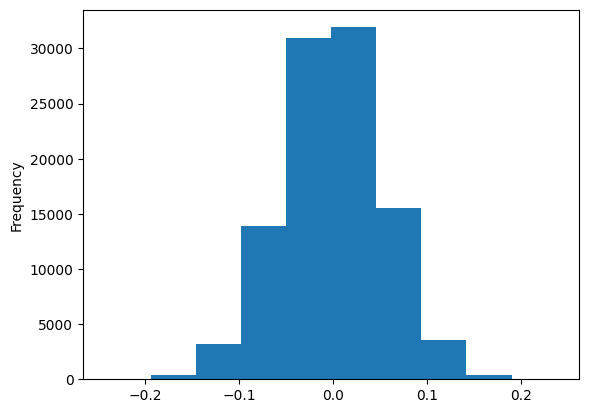

In [ ]:
case_df['mean'].plot.hist() # 포트폴리오 수익 평균의 분포

In [ ]:
case_df['sharp'] = case_df['mean'] / case_df['std'] # 나만의 샤프~

<Axes: ylabel='Frequency'>

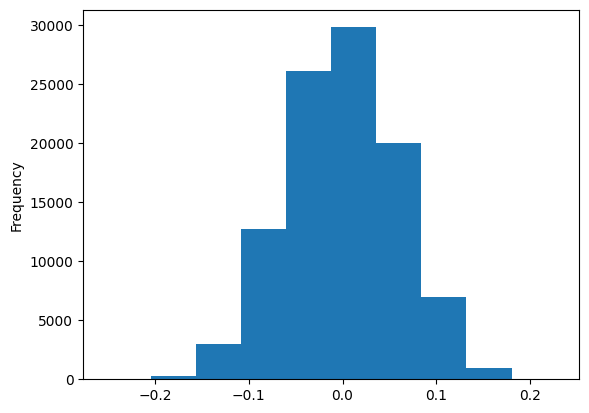

In [ ]:
case_df['sharp'].plot.hist() # 샤프의 분포

In [ ]:
case_df.sort_values('sharp').reset_index(drop=True)

,mean,std,sharp
0,-0.241737,0.957405,-0.252492
1,-0.165055,0.678396,-0.243302
2,-0.186037,0.809479,-0.229823
3,-0.173515,0.757743,-0.228989
4,-0.156653,0.689391,-0.227233
...,...,...,...
99995,0.162682,0.738028,0.220429
99996,0.148335,0.666508,0.222556
99997,0.161316,0.722605,0.223242
99998,0.154744,0.688558,0.224736


<Axes: >

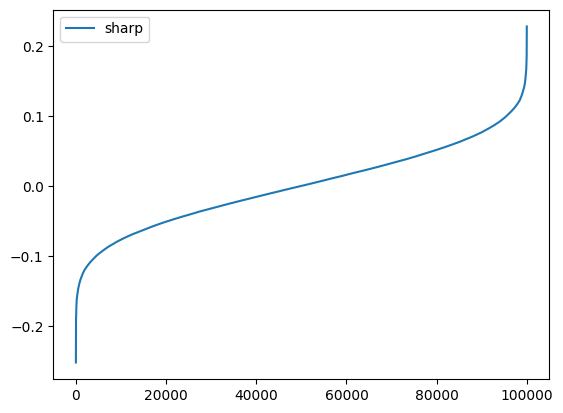

In [ ]:
case_df.sort_values('sharp').reset_index(drop=True)[['sharp']].plot()

<Axes: xlabel='index', ylabel='sharp'>

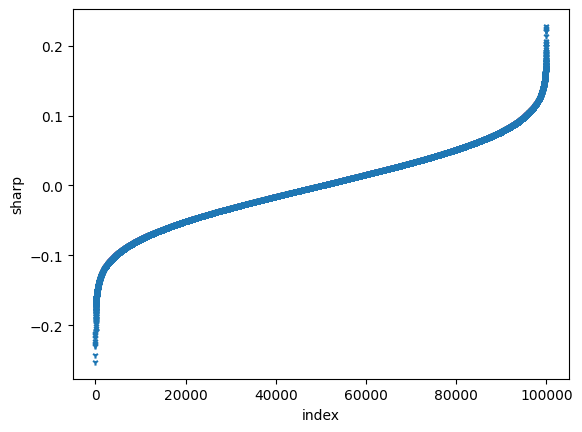

In [ ]:
case_df.sort_values('sharp').reset_index(drop=True).reset_index().plot.scatter(x='index',y='sharp',marker='1')

위 방법으로도 효과가 좋은 포트폴리오 구성도 가능할 것 입니다~
(제가 이 방법으로 점수를 올려야 하나 오늘 3번 다 제출해서 못하네요 ㅜ.ㅜ)

물론 CAPM과 같은 방법 또한 사용 가능하나, 제가 너무 오래전에 배운 것 이라

다시 공부해봐야 할 것 같네요.

만약 반응이 좋으면 다음편으로 CAPM 공부해서 업로드 해보겠습니다.